## Install dependencies:

In [1]:
!pip install matplotlib keras pandas --user
!python --version

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Python 3.7.4


## Hotfix docker permissions:

In [ ]:
!chmod 777 -R /home/jovyan # hotfix docker permissions

In [193]:
# from pprint import pprint
import io
# work with images
import itertools
from datetime import datetime
from random import random
from typing import List, Dict, Any, Tuple

import cv2
# face detection
import face_recognition as fr
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image, ImageFilter
from matplotlib.image import pil_to_array
from mtcnn import MTCNN

import sys
sys.path.append('./BdDetector')
from BdDetector import BdDetector

face_detector = MTCNN()
bd_detector = BdDetector("prediction_models/2000-bd-single-color-1.0/deploy_model_algo_1")

# minimum detected face dimension in pixels
MIN_FACE_SIZE = 90

def area(rect):
    width, height = rect['xmax'] - rect['xmin'], rect['ymax'] - rect['ymin']
    return width * height


def area_overlap(rect1, rect2):
    dx = min(rect1['xmax'], rect2['xmax']) - max(rect1['xmin'], rect2['xmin'])
    dy = min(rect1['ymax'], rect2['ymax']) - max(rect1['ymin'], rect2['ymin'])
    if (dx >= 0) and (dy >= 0):
        return dx * dy


def show_faces(faces, img):
    """
    Use Matplotlib to display an image with highlighted faces.

    :param faces:
    :param img:
    """
    for face in faces:
        box = face['box']
        cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 0, 0), 10)
    plt.imshow(img)
    plt.show()


def convert_box(box):
    """
    Convert a box used by MTCNN (x,y,width,weight)
    to a box used by face_recognition (y1,x2,y2,x1)

    :param box:
    :return:
    """
    return box[1], box[0] + box[2], box[1] + box[3], box[0]


def split_img_vertically(img: Image.Image) -> Tuple[Image.Image, Image.Image]:
    """
    Split an image in half along its Y axis.

    :return: A list: [ left_half, right_half ]
    """
    width, height = img.size
    img_left = img.crop((0, 0, width / 2, height))
    img_right = img.crop((width / 2, 0, width, height))
    return img_left, img_right



def blur_boxes(img: Image.Image, boxes: []) -> Image.Image:
    for box in boxes:
        xmin, ymin = box['xmin'], box['ymin']
        xmax, ymax = box['xmax'], box['ymax']
        
        blurred = img.crop((xmin, ymin, xmax, ymax))
        blurred = blurred.filter(ImageFilter.GaussianBlur(15))
        img_pixels = img.load()
        blurred_pixels = blurred.load()
        
        for i in range(blurred.size[0]):
            for j in range(blurred.size[1]):
                img_pixels[i+xmin,j+ymin] = blurred_pixels[i,j]
    
    return img

def visualize_detections(img: Image.Image, results: [], classes=[], colors=[]) -> Image.Image:
    """
    visualize detections in one image
    Parameters:
    ----------
    img : numpy.array
        image, in bgr format
    dets : numpy.array
        ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
        each row is one object
    classes : tuple or list of str
        class names
    thresh : float
        score threshold
    """

    np_img = pil_to_array(img)
    fig, ax = plt.subplots(1)
    ax.imshow(np_img)
    
    # if no colors are specified, pick random color for each object class
    if len(colors) == 0:
        for cls in classes:
            colors.append((random(), random(), random()))

    for result in results:
        xmin, ymin = result['xmin'], result['ymin']
        xmax, ymax = result['xmax'], result['ymax']
        score = result['score']

        # draw each object class with identical color
        class_name = result['class']
        class_id = classes.index(result['class'])
        color = colors[class_id]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=color,
                                 linewidth=1)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor=color, alpha=0.5),
                fontsize=12, color='white')
        
    
    plt.show()

    # convert to PIL image
#     with io.BytesIO() as buf:
#         plt.savefig(buf, format='png', dpi=500)
#         buf.seek(0)
#         im = Image.open(buf)
#         return im

def mtcnn_detect_faces(img: Image.Image):
    np_img = np.array(img)
    faces = face_detector.detect_faces(np_img)

    faces_formatted = []
    for face in faces:
        box = face['box']
        faces_formatted.append({
            'xmin': box[0],
            'ymin': box[1],
            'xmax': box[0] + box[2],
            'ymax': box[1] + box[3],
            'score': face['confidence'],
            'keypoints': face['keypoints'],
            'class': 'face'
        })
    return faces_formatted



def get_encodings(img: Image.Image, faces: List[Dict]) -> List[List[np.ndarray]]:
    """
    Get face vector representations of faces found on an image.

    :param img: PIL Image containing faces to encode.
    :param split: if True, split the image into two vertically and extract an encoding from each
    :return: A list:
             *  Each item is the face vector representation of the largest face (by area) found on picture.
             *  If split=True contains two elements, otherwise only one.
    """
    
    # (y1,x2,y2,x1)
    fr_boxes = []
    for face in faces:
        fr_boxes.append((
            face['ymin'],
            face['xmax'],
            face['ymax'],
            face['xmin']
        ))

    return fr.face_encodings(np.array(img), known_face_locations=fr_boxes)


def clear_small_faces(faces):
    """
    Remove detections that do not match the MIN_FACE_SIZE requirement.
    """
    large_faces = []
    for face in faces:
        width, height = face['xmax'] - face['xmin'], face['ymax'] - face['ymin']
        if width < MIN_FACE_SIZE or height < MIN_FACE_SIZE:
            continue
        large_faces.append(face)
    return large_faces

data_names: ['data']
output_names: ['detection_output']


## Split glued pictures:

In [227]:
from glob import glob
import os

SET_PATH = './passing-set/1'
# SET_PATH = './failing-set/1'

# get data from generator so files do not enter twice
paths = []
for i,path in enumerate(glob(f"{SET_PATH}/unsplit/*.png")):
    paths.append((i,path))

for i,path in paths:
    img = Image.open(path)
    
    
    left, right = split_img_vertically(img)
    
    print(i)
    basename = os.path.basename(path)
    left.save(f"{SET_PATH}/{i}l.png")
    right.save(f"{SET_PATH}/{i}r.png")

0
1


In [222]:
def multi_check(img: Image.Image, pfp: Image.Image) -> bool:
    """
    :param img: Run check on this image
    :param pfp: Profile picture for face recognition
    """
    # detect faces and bds from img
    faces = mtcnn_detect_faces(img)
    
    bds = bd_detector.predict(img)
    
    # prepare profile pic encoding
    pfp_location = mtcnn_detect_faces(pfp)
    pfp_encoding = get_encodings(pfp, pfp_location)[0] # pfp only contains one face
    
    
    # print(f"bds:{len(bds)},faces:{len(faces)}")
    
    # put together objects for visualizations
    results = []
    results.extend(bds)
    results.extend(faces)
    
    # case: failed to detect face or device
    if len(bds) == 0 or len(faces) == 0:
        return False, results
    
    encodings = get_encodings(img, faces)
    
    # interface:
    # fr.compare_faces(
    # [KNOWN_FACES]: list
    # NEW_FACE: encoding
    # )
    recognition_results = fr.compare_faces(encodings, pfp_encoding)
    # print(recognition_results)
    
    
    subject_faces = []
    for i,face in enumerate(faces):
        if recognition_results[i]:
            subject_faces.append(face)
    
    # subject should not appear multiple times in the same photo
    if len(subject_faces) > 1:
        return False, results
    
    # subject not detected in the photo
    if len(subject_faces) == 0:
        return False, results
    
    subject = subject_faces[0]
    # set separate class for subject
    faces.remove(subject)
    subject['class'] = 'subject'
    results.append(subject)
    
    overlaps = []
    max_overlap = None
    subjects_bd = None
    for bd in bds:
        overlap = area_overlap(subject, bd)
        if max_overlap == None or overlap > max_overlap:
            max_overlap = overlap
            subjects_bd = bd
    
    # device used by a different person
    if max_overlap == None or max_overlap == 0:
        return False, results
    
    if subjects_bd == None:
        return False, results
    
    print(subject)
    nosey, nosex = subject['keypoints']['nose']
    
    bd_height = subjects_bd['ymax'] - subjects_bd['ymin']
    bd_middle = subjects_bd['ymin'] + bd_height / 2
    
    if nosey > bd_middle:
        return False, results
    
    
    return True, results

./failing-set/1/5r.png


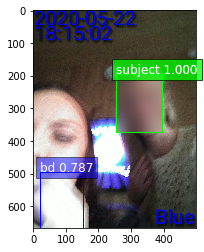

TEST FAILED
./failing-set/1/3r.png


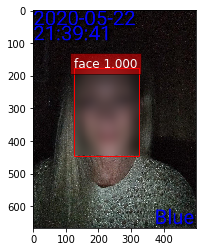

TEST FAILED
./failing-set/1/1l.png


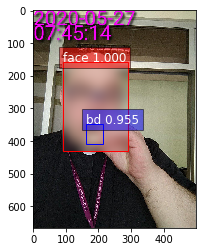

TEST FAILED
./failing-set/1/2l.png


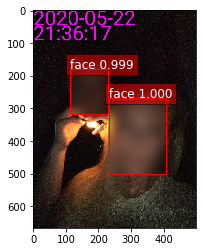

TEST FAILED
./failing-set/1/2r.png


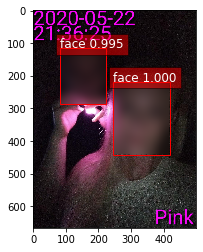

TEST FAILED
./failing-set/1/4r.png


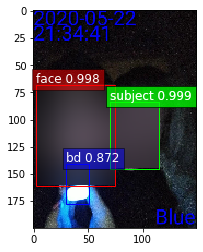

TEST FAILED
./failing-set/1/0r.png


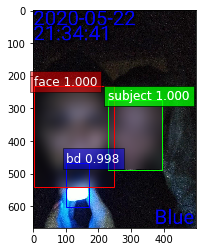

TEST FAILED


In [224]:
FAILING_SET_PATH = './failing-set/1'

pfp = Image.open(f"{FAILING_SET_PATH}/profile/1.png") # profile picture

for path in glob(f"{FAILING_SET_PATH}/*.png"):
    print(path)
    img = Image.open(path)
    passed, detections = multi_check(img, pfp)
    
    
    blurred_boxes = []
    for d in detections:
        if d['class'] == 'face' or d['class'] == 'subject':
            blurred_boxes.append(d)
        

    # blur persons before visualizing
    blurred = blur_boxes(img, blurred_boxes)
    
    # visualize
    visualized = visualize_detections(
        img = blurred,
        results = detections,
        classes = ['face', 'bd', 'subject'],
        colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]
    )

    if passed:
        print("TEST PASSED")
    else:
        print("TEST FAILED")

./passing-set/1/1r.png
{'xmin': 237, 'ymin': 235, 'xmax': 424, 'ymax': 476, 'score': 0.999998927116394, 'keypoints': {'left_eye': (278, 323), 'right_eye': (367, 321), 'nose': (322, 359), 'mouth_left': (290, 415), 'mouth_right': (368, 412)}, 'class': 'subject'}


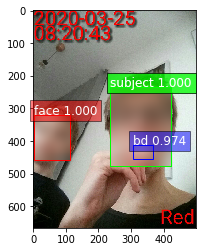

TEST PASSED
./passing-set/1/0l.png


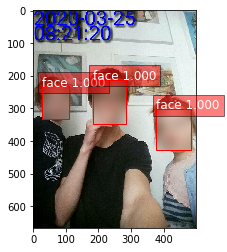

TEST FAILED


In [228]:
PASSING_SET_PATH = './passing-set/1'
pfp = Image.open(f"{PASSING_SET_PATH}/profile/1.png") # profile picture

for path in glob(f"{PASSING_SET_PATH}/*.png"):
    print(path)
    img = Image.open(path)
    passed, detections = multi_check(img, pfp)
    
    
    blurred_boxes = []
    for d in detections:
        if d['class'] == 'face' or d['class'] == 'subject':
            blurred_boxes.append(d)
        

    # blur persons before visualizing
    blurred = blur_boxes(img, blurred_boxes)
    
    # visualize
    visualized = visualize_detections(
        img = blurred,
        results = detections,
        classes = ['face', 'bd', 'subject'],
        colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]
    )
    if passed:
        print("TEST PASSED")
    else:
        print("TEST FAILED")

./failing-set/3/1r.png
{'xmin': 69, 'ymin': 122, 'xmax': 345, 'ymax': 476, 'score': 0.9999972581863403, 'keypoints': {'left_eye': (145, 260), 'right_eye': (272, 272), 'nose': (202, 334), 'mouth_left': (144, 394), 'mouth_right': (244, 407)}, 'class': 'subject'}


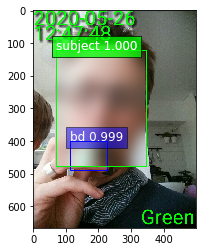

TEST PASSED
./failing-set/3/3l.png
{'xmin': 143, 'ymin': 71, 'xmax': 412, 'ymax': 412, 'score': 0.9997009038925171, 'keypoints': {'left_eye': (224, 197), 'right_eye': (345, 187), 'nose': (286, 243), 'mouth_left': (236, 328), 'mouth_right': (343, 315)}, 'class': 'subject'}


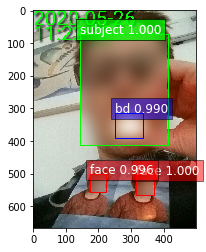

TEST PASSED
./failing-set/3/3r.png
{'xmin': 140, 'ymin': 83, 'xmax': 402, 'ymax': 424, 'score': 0.9999279975891113, 'keypoints': {'left_eye': (211, 209), 'right_eye': (337, 201), 'nose': (279, 264), 'mouth_left': (227, 337), 'mouth_right': (337, 335)}, 'class': 'subject'}


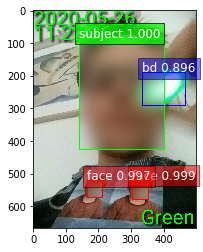

TEST FAILED
./failing-set/3/0l.png
{'xmin': 335, 'ymin': 138, 'xmax': 512, 'ymax': 384, 'score': 0.9996706247329712, 'keypoints': {'left_eye': (407, 248), 'right_eye': (475, 214), 'nose': (477, 278), 'mouth_left': (440, 338), 'mouth_right': (503, 306)}, 'class': 'subject'}


IndexError: image index out of range

In [229]:
FAILING_SET_PATH = './failing-set/3'

pfp = Image.open(f"{FAILING_SET_PATH}/profile/3.png") # profile picture

for path in glob(f"{FAILING_SET_PATH}/*.png"):
    print(path)
    img = Image.open(path)
    passed, detections = multi_check(img, pfp)
    
    
    blurred_boxes = []
    for d in detections:
        if d['class'] == 'face' or d['class'] == 'subject':
            blurred_boxes.append(d)
        

    # blur persons before visualizing
    blurred = blur_boxes(img, blurred_boxes)
    
    # visualize
    visualized = visualize_detections(
        img = blurred,
        results = detections,
        classes = ['face', 'bd', 'subject'],
        colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]
    )

    if passed:
        print("TEST PASSED")
    else:
        print("TEST FAILED")